# Aviation Risk Prediction Intelligence — EDA (Exploratory Data Analysis)

This notenook analyse the enriched dataset that is the fusion between : 
- The real flights data (OpenSky Network) located in  `src/ingestion/opensky_ingest.py`
- Meteorological Airport Report data (METAR) located `src/ingestion/metar_ingest.py`

Objectives :
- Understand data structures
- detect anomalies
- identify flights and meteorological conditions patterns
- Prepare the feature engineering necessary for the Machine Learning

The analysis is done on the most recent enriched file available in `data/processed/`.

In [98]:
import sys
sys.path.append("..")

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone

from src.utils import get_latest_file

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [100]:
import os
print("Working directory:", os.getcwd())

Working directory: c:\Projects\aviation-risk-project\notebooks


In [101]:
pattern = "../data/processed/flights_enriched_*.csv"

filepath = get_latest_file(pattern)

print("Loaded File:", filepath)

df=pd.read_csv(filepath)

df.head()

Loaded File: ../data/processed\flights_enriched_20251210_173141.csv


,icao24,callsign,origin_country,time_position,last_contact,longitude,latitude,baro_altitude,on_ground,velocity,...,metar_metarType,metar_rawOb,metar_lat,metar_lon,metar_elev,metar_name,metar_cover,metar_clouds,metar_fltCat,metar_fetch_time_utc
0,80162c,AXB522,India,1.765380e+09,1765379869,55.6938,24.0396,10668.00,False,251.49,...,METAR,METAR LFPG 101600Z 27006KT 9999 BKN030 BKN190 ...,49.015,2.534,107,"Paris/De Gaulle Arpt, ID, FR",BKN,"[{'cover': 'BKN', 'base': 3000}, {'cover': 'BK...",MVFR,2025-12-10 16:20:04.386928+00:00
1,801638,AXB1120,India,1.765380e+09,1765379869,77.9913,27.8394,8839.20,False,252.36,...,METAR,METAR LFPG 101600Z 27006KT 9999 BKN030 BKN190 ...,49.015,2.534,107,"Paris/De Gaulle Arpt, ID, FR",BKN,"[{'cover': 'BKN', 'base': 3000}, {'cover': 'BK...",MVFR,2025-12-10 16:20:04.386928+00:00
2,408120,VIR47GH,United Kingdom,1.765380e+09,1765379869,-3.3146,51.7957,8191.50,False,183.03,...,METAR,METAR LFPG 101600Z 27006KT 9999 BKN030 BKN190 ...,49.015,2.534,107,"Paris/De Gaulle Arpt, ID, FR",BKN,"[{'cover': 'BKN', 'base': 3000}, {'cover': 'BK...",MVFR,2025-12-10 16:20:04.386928+00:00
3,88044a,AIQ3228,Thailand,1.765380e+09,1765379870,100.0653,12.0238,11277.60,False,239.34,...,METAR,METAR LFPG 101600Z 27006KT 9999 BKN030 BKN190 ...,49.015,2.534,107,"Paris/De Gaulle Arpt, ID, FR",BKN,"[{'cover': 'BKN', 'base': 3000}, {'cover': 'BK...",MVFR,2025-12-10 16:20:04.386928+00:00
4,a2e5ec,SKW4128,United States,1.765380e+09,1765379869,-122.9854,44.2956,3444.24,False,171.99,...,METAR,METAR LFPG 101600Z 27006KT 9999 BKN030 BKN190 ...,49.015,2.534,107,"Paris/De Gaulle Arpt, ID, FR",BKN,"[{'cover': 'BKN', 'base': 3000}, {'cover': 'BK...",MVFR,2025-12-10 16:20:04.386928+00:00


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   icao24                10357 non-null  object 
 1   callsign              10175 non-null  object 
 2   origin_country        10357 non-null  object 
 3   time_position         10251 non-null  float64
 4   last_contact          10357 non-null  int64  
 5   longitude             10251 non-null  float64
 6   latitude              10251 non-null  float64
 7   baro_altitude         9356 non-null   float64
 8   on_ground             10357 non-null  bool   
 9   velocity              10356 non-null  float64
 10  true_track            10357 non-null  float64
 11  vertical_rate         9382 non-null   float64
 12  sensors               0 non-null      float64
 13  geo_altitude          9258 non-null   float64
 14  squawk                5973 non-null   float64
 15  spi                

## Data Overview

To better understand the dataset and check whether it contains a lot of missing values, we first used the `df.info()`command.

This allow us to draw some initial conclusions that will help us with the next step which is transforming and cleaning data.

In this case, we can see that most of the flight-related variables are well populated.

That means that the dataset contains enough useful information to perform meaningful analysis without heavy data loss early on.

In [103]:
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate

sensors                 1.000000
squawk                  0.423289
geo_altitude            0.106112
baro_altitude           0.096650
vertical_rate           0.094139
callsign                0.017573
longitude               0.010235
time_position           0.010235
latitude                0.010235
velocity                0.000097
icao24                  0.000000
last_contact            0.000000
origin_country          0.000000
true_track              0.000000
on_ground               0.000000
spi                     0.000000
position_source         0.000000
fetch_time_utc          0.000000
metar_icaoId            0.000000
metar_receiptTime       0.000000
metar_obsTime           0.000000
metar_reportTime        0.000000
metar_temp              0.000000
metar_dewp              0.000000
metar_wdir              0.000000
metar_wspd              0.000000
metar_visib             0.000000
metar_altim             0.000000
metar_qcField           0.000000
metar_metarType         0.000000
metar_rawO

In [104]:
df = df.drop(columns='sensors')
df.shape

(10357, 38)

In [105]:
df["squawk"].value_counts(dropna=False).head(10)

squawk
NaN       4384
1000.0     434
1200.0      88
7000.0      64
2000.0       9
2657.0       7
4000.0       6
3277.0       6
543.0        6
2630.0       6
Name: count, dtype: int64

In [106]:
df = df.drop(columns="squawk")
df.shape

(10357, 37)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   icao24                10357 non-null  object 
 1   callsign              10175 non-null  object 
 2   origin_country        10357 non-null  object 
 3   time_position         10251 non-null  float64
 4   last_contact          10357 non-null  int64  
 5   longitude             10251 non-null  float64
 6   latitude              10251 non-null  float64
 7   baro_altitude         9356 non-null   float64
 8   on_ground             10357 non-null  bool   
 9   velocity              10356 non-null  float64
 10  true_track            10357 non-null  float64
 11  vertical_rate         9382 non-null   float64
 12  geo_altitude          9258 non-null   float64
 13  spi                   10357 non-null  bool   
 14  position_source       10357 non-null  int64  
 15  fetch_time_utc     

In [108]:
df["time_position_dt"] = pd.to_datetime(df["time_position"], unit="s", utc=True)
df["last_contact_dt"] = pd.to_datetime(df["last_contact"], unit="s", utc=True)
df["metar_obsTime_dt"] = pd.to_datetime(df["metar_obsTime"], unit="s", utc=True)

snapshot_time_utc = df["last_contact_dt"].max()

snapshot_time_utc

Timestamp('2025-12-10 15:17:50+0000', tz='UTC')

In [109]:
df[[
    "time_position_dt",
    "last_contact_dt",
    "metar_obsTime_dt"
]].describe()

,time_position_dt,last_contact_dt,metar_obsTime_dt
count,10251,10357,10357
mean,2025-12-10 15:17:19.119695360+00:00,2025-12-10 15:17:28.874674176+00:00,2025-12-10 16:00:00+00:00
min,2025-12-10 10:10:30+00:00,2025-12-10 15:12:35+00:00,2025-12-10 16:00:00+00:00
25%,2025-12-10 15:17:47+00:00,2025-12-10 15:17:48+00:00,2025-12-10 16:00:00+00:00
50%,2025-12-10 15:17:49+00:00,2025-12-10 15:17:49+00:00,2025-12-10 16:00:00+00:00
75%,2025-12-10 15:17:49+00:00,2025-12-10 15:17:49+00:00,2025-12-10 16:00:00+00:00
max,2025-12-10 15:17:50+00:00,2025-12-10 15:17:50+00:00,2025-12-10 16:00:00+00:00


In [110]:
df.groupby("on_ground")[["baro_altitude","geo_altitude"]].describe()

baro_altitude                                                      \
                  count         mean          std     min      25%      50%   
on_ground                                                                     
False            9309.0  6677.706658  4379.766736 -182.88  1943.10  7734.30   
True               47.0  1848.903830  5040.325150  -15.24   335.28   358.14   

                              geo_altitude                                   \
                75%       max        count         mean          std    min   
on_ground                                                                     
False      10866.12  22920.96       9258.0  6785.314517  4445.200125 -22.86   
True         365.76  26883.36          0.0          NaN          NaN    NaN   

                                                  
                25%      50%       75%       max  
on_ground                                         
False      1967.865  7871.46  10980.42  14980.92  
True            NaN      NaN       NaN       NaN

In [111]:
df.groupby("on_ground")["velocity"].describe()

# the velocity is in meter per second

,count,mean,std,min,25%,50%,75%,max
on_ground,,,,,,,,
False,9406.0,167.391819,75.486686,0.0,97.8975,192.575,228.405,743.54
True,950.0,5.041589,12.164251,0.0,0.0000,2.830,6.430,235.39


In [112]:
df[["latitude","longitude"]].describe()

,latitude,longitude
count,10251.000000,10251.000000
mean,36.456446,-44.543992
std,13.868548,64.960188
min,-54.964900,-164.783500
25%,31.957300,-94.155650
50%,38.085700,-78.913200
75%,43.692000,7.892250
max,69.169900,176.874500


In [113]:
df_airborne = df[df["on_ground"]==False].copy()
df_airborne["baro_altitude"].describe()


count     9309.000000
mean      6677.706658
std       4379.766736
min       -182.880000
25%       1943.100000
50%       7734.300000
75%      10866.120000
max      22920.960000
Name: baro_altitude, dtype: float64

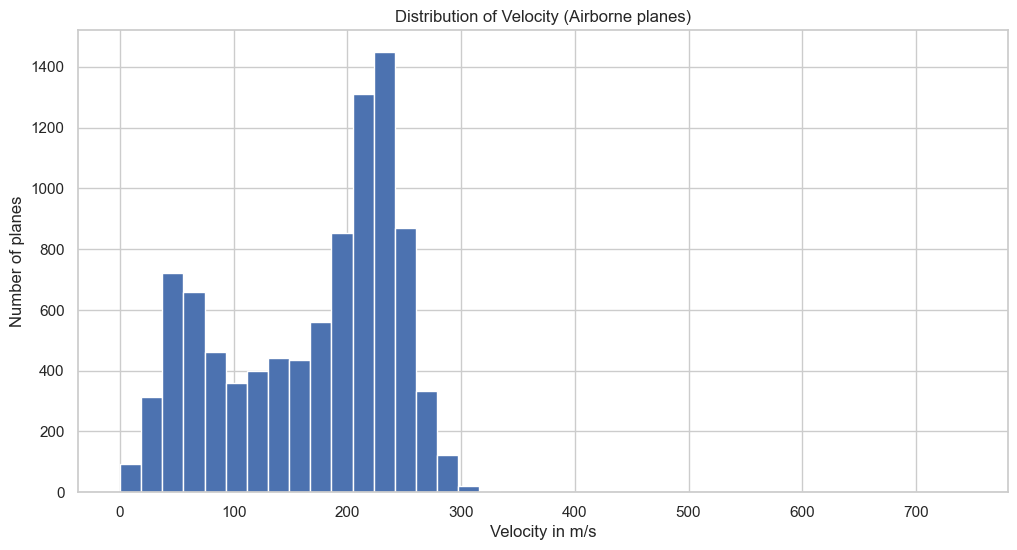

In [114]:
plt.hist(df_airborne["velocity"], bins=40)
plt.xlabel("Velocity in m/s")
plt.ylabel("Number of planes")
plt.title("Distribution of Velocity (Airborne planes)")
plt.show()

In [115]:
df_airborne["velocity_kmh"] = df_airborne["velocity"] * 3.6
df_airborne["velocity_kmh"].describe()


count    9406.000000
mean      602.610549
std       271.752070
min         0.000000
25%       352.431000
50%       693.270000
75%       822.258000
max      2676.744000
Name: velocity_kmh, dtype: float64

In [116]:
df_airborne["velocity_kmh"].quantile([0.01, 0.05, 0.95, 0.99])


0.01      71.6058
0.05     141.6600
0.95     938.8620
0.99    1020.6270
Name: velocity_kmh, dtype: float64

In [117]:
df_airborne["low_speed_flag"] = df_airborne["velocity_kmh"] < 150
df_airborne["high_speed_flag"] = df_airborne["velocity_kmh"] > 950

df_airborne[["low_speed_flag", "high_speed_flag"]].mean()


low_speed_flag     0.058686
high_speed_flag    0.043270
dtype: float64

In [118]:
df_airborne["high_altitude_flag"] = df_airborne["baro_altitude"] > 13000
df_airborne["negative_altitude_flag"] = df_airborne["baro_altitude"] < 0

df_airborne[["high_altitude_flag", "negative_altitude_flag"]].mean()


high_altitude_flag        0.016585
negative_altitude_flag    0.001488
dtype: float64

In [119]:
df_airborne[["metar_fltCat","metar_wdir","metar_wspd","metar_temp","metar_dewp"]].describe(include="all")


,metar_fltCat,metar_wdir,metar_wspd,metar_temp,metar_dewp
count,9406,9406.0,9406.0,9406.0,9406.0
unique,1,NaN,NaN,NaN,NaN
top,MVFR,NaN,NaN,NaN,NaN
freq,9406,NaN,NaN,NaN,NaN
mean,NaN,270.0,6.0,13.0,8.0
std,NaN,0.0,0.0,0.0,0.0
min,NaN,270.0,6.0,13.0,8.0
25%,NaN,270.0,6.0,13.0,8.0
50%,NaN,270.0,6.0,13.0,8.0
75%,NaN,270.0,6.0,13.0,8.0


In [120]:
df_airborne["risk_score"] = (df_airborne["high_speed_flag"].astype(int) +df_airborne["low_speed_flag"].astype(int) +df_airborne["high_altitude_flag"].astype(int))
df_airborne["risk_score"].describe()


count    9406.000000
mean        0.118541
std         0.325233
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: risk_score, dtype: float64

In [121]:
df_airborne["risk_score"].value_counts(normalize=True).sort_index()

risk_score
0    0.882097
1    0.117266
2    0.000638
Name: proportion, dtype: float64

In [122]:
df_airborne.groupby("risk_score")[["high_speed_flag","low_speed_flag","high_altitude_flag","negative_altitude_flag"]].mean()

,high_speed_flag,low_speed_flag,high_altitude_flag,negative_altitude_flag
risk_score,,,,
0,0.000000,0.000000,0.000000,0.001326
1,0.363554,0.500453,0.135993,0.002720
2,1.000000,0.000000,1.000000,0.000000


<Axes: xlabel='risk_score', ylabel='velocity_kmh'>

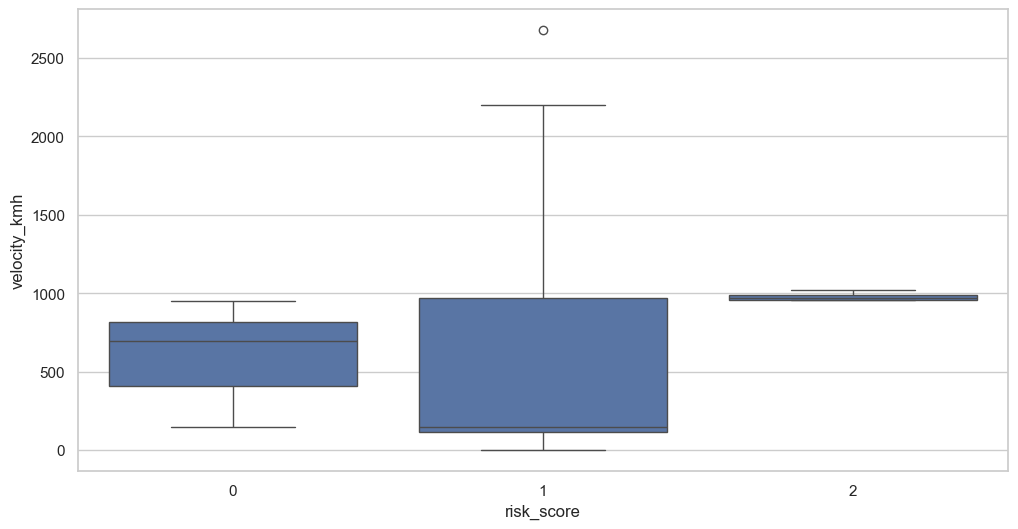

In [123]:
import seaborn as sns

sns.boxplot(
    data=df_airborne,
    x="risk_score",
    y="velocity_kmh"
)


<Axes: xlabel='risk_score', ylabel='baro_altitude'>

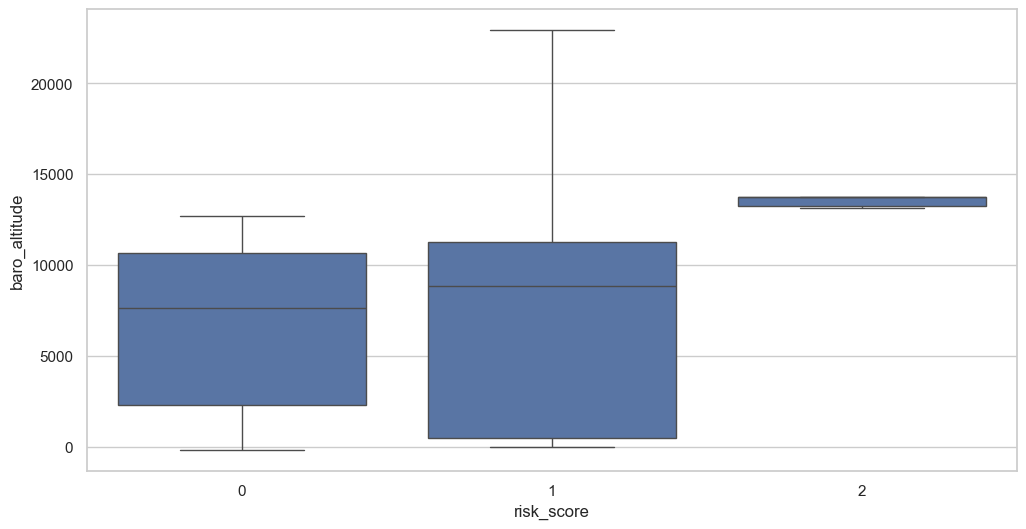

In [124]:
sns.boxplot(
    data=df_airborne,
    x="risk_score",
    y="baro_altitude"
)
